<h1>ERCC Counting Workflow</h1>

**To provide meaningful results, this workflow requires sequencing data which has had ERCC spiked-in.**

The External RNA Controls Consortium (ERCC) has created an RNA control, consisting of 92 transcripts, each between 250 and 2000 nucleotides long, representative of eukaryotic mRNAs. Variability within RNA or cDNA sequencing experiments can arise from multiple sources, including but not limited to variation between samples, sample extraction and library preparation stages, flow-cell loading, and the types as well as batch of flow-cells and devices employed. Determining whether variation is genuine or instead error arising from one of these sources can be difficult, but a control can help.

In the ERCC control mixes, each of the 92 transcripts is present at a different known concentration. We employ the [Lexogen SIRV set3](https://www.lexogen.com/store/sirv-set3/) kit as standard. As such, assuming that the ERCCs have been added to your library, it is possible to measure whether the sequencing data recapitulates their expected concentrations. If so, this lends evidence that the sequencing process is relatively unbiased, and that your data should be quantiatively representative of the input sample (notwithstanding some caveats).

In this workflow, we first perform alignment of our sequencing data to the ERCC and Host reference sequences, and then count these alignments to produce a range of summary statistics, including the correlation between the number of observations of each ERCC with their expected counts.

Computational requirements for this tutorial include:

* Computer running the **EPI2ME Labs** notebook Server
* At least 4 CPU Cores
* At least 16Gb RAM

> ⚠️ **Warning:** This notebook has been saved with its outputs for demostration purposed. It is recommended to select `Edit > Clear all outputs` before using the notebook to analyse your own data.


## Getting started

The workflow provides all the necessary standard reference data as well as sample sequencing data which you can use to perform a trial run of the workflow.
Both the reference and sample data can be changed manually, as we will see later. Before anything else we will create and set a working directory.

In [541]:
# Runs some initialisation for the workflow /epi2melabs/ercc_workflow (Click play)
from epi2melabs import ping
pinger = ping.Pingu()
pinger.send_notebook_ping('start', 'ercc_workflow')

# create a work directory and move into it
tutorial_name = "ercc_workflow"
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/ercc_workflow


### Reference & test data

Next we will acquire the necessary reference data and sample sequencing data. Here is a description of each item we will download:

- ERCC reference `.fasta`: A file containing the ERCC sequences which are our control
- ERCC expected counts `.csv`: A file provided by Lexogen containing an expected count for each ERCC sequence in their mix
- HG38 (Human) reference `.fasta`: The Host reference sequence, which is Human by default
- PCS110_90pg_grid_r941 `.fastq`: A directory of human sequencing data with ERCC spiked-in

>  **Why include a host reference in addition to ERCC?** Including the Host reference sequence makes the job marginally harder for our aligner during the alignment stage, meaning it is less likely to produce a false positive alignment to an ERCC that could be better explained by aligning to the Host. In addition, statistics calculated from host alignment may be of interest.

In [545]:
# Download the various reference data (Click play)
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

# Download the ERCC reference
!wget "$site"/ercc_workflow/ERCC.fas

# Download the ERCC counts
!wget "$site"/ercc_workflow/ERCC_mix1.csv

# Download the human reference
!wget "$site"/grch38.tar.gz
!tar -xzvf grch38.tar.gz
!cd grch38 && gunzip grch38.fasta.gz && cd ..

# Sample sequence data
!wget "$site"/ercc_workflow/PCS110_90pg_grid_r941.tar.gz
!tar -xzvf PCS110_90pg_grid_r941.tar.gz
!cd PCS110_90pg_grid_r941 && gunzip *.fastq.gz && cd ..

--2020-12-11 00:04:23--  https://ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com/ercc_workflow/ERCC.fas
Resolving ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com (ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com)... 52.218.60.192
Connecting to ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com (ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com)|52.218.60.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83952 (82K) [binary/octet-stream]
Saving to: ‘ERCC.fas.3’

ERCC.fas.3          100%[===================>]  81.98K  --.-KB/s    in 0.07s   

2020-12-11 00:04:24 (1.11 MB/s) - ‘ERCC.fas.3’ saved [83952/83952]

--2020-12-11 00:04:27--  https://ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com/ercc_workflow/ERCC_mix1.csv
Resolving ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com (ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com)... 52.218.60.192
Connecting to ont-exd-int

### Setting workflow inputs

We must now set the workflow inputs by assigning variables to the data paths. In the cell below we produce a form which you can use to set the paths. By default, the inputs will point to the reference and sample data we downloaded in the previous step, but you are free to change these paths to whatever you like. In particular:

- **Experiment**

    The value of this setting will be used to create a so-named folder, into which all the workflow results will be stored. If you wish to re-run the workflow and keep the previous results, it is wise to change this value.

- **Input .fastq**

    This setting will store the path to the sequencing data which we wish to analyse. By default it will point to the sample data. If you want to use your own data, you should specify a path to a directory containing `.fastq` files. To find the correct full path of a directory you can navigate to it in the `Files` browser to the left-hand side, right-click on the file and select `Copy path` (shown in the screenshot below).

    The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.

After you have reviewed the workflow inputs, press the `> Enter` button.

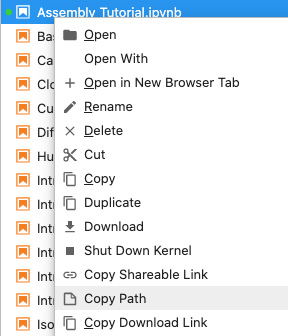

In [546]:
# Code required for input form generation and should autorun at launch. (Expandable)
import os
import aplanat
import pandas as pd
import aplanat.graphics
from epi2melabs.notebook import InputForm, InputSpec

experiment = None
input_data = None
host_reference_fasta = None
ercc_reference_fasta = None
ercc_concentrations_csv = None


def process_form(
    inputs
):
    global experiment
    global input_data
    global host_reference_fasta
    global ercc_reference_fasta
    global ercc_concentrations_csv

    for i in [*inputs][1:]:
        if not os.path.exists(i[1]):
            raise ValueError(
                '{} path does not exist. '
                'Please check and try again.'
                .format(i[0])
            )

    experiment = inputs.experiment
    input_data = inputs.input_data
    host_reference_fasta = inputs.host_reference_fasta
    ercc_reference_fasta = inputs.ercc_reference_fasta
    ercc_concentrations_csv = inputs.ercc_concentrations_csv

desc = (
    "Enter the paths to you input files and output folder here."
    "The input data may be either a a single fastq, compressed or"
    "otherwise, file or a directory containing multiple such files"
)

input_form = InputForm(
    InputSpec('experiment', 'Experiment', 'ERCC-Counting'),
    InputSpec('input_data', 'Input .fastq', 'PCS110_90pg_grid_r941'),
    InputSpec('ercc_reference_fasta', 'ERCC reference .fasta', 'ERCC.fas'),
    InputSpec('ercc_concentrations_csv', 'ERCC counts .csv', 'ERCC_mix1.csv'),
    InputSpec('host_reference_fasta', 'Host reference .fasta', 'grch38/grch38.fasta'),
)

input_form.add_process_button(process_form)
input_form.display()

## Workflow - Analyse

Now that we have our inputs saved, we can begin our analysis. We will conduct the following workflow:

> Demultiplexing -> Concatenation -> Alignment -> Counting

### Demultiplexing

The goal of demultiplexing is to split our `.fastq` sequencing data into barcoded groups corresponding to any barcodes used during library preparation. We use the guppy_barcoder command line tool to perform this step for us. 

> ⚠️ **Notice:** If you have changed the input data and have not used barcodes in your experiment, do not worry, you can safely run this step. If, however, you already have demultiplexed data and a barcoding summary and do not want to re-demultiplex it, then simply replace the paths in the concatenation workflow step with the location at which your data can be found.

In [551]:
!guppy_barcoder -i $input_data --save_path $experiment/guppy_barcoder


ONT Guppy barcoding software version 4.2.2+effbaf8
input path:         PCS110_90pg_grid_r941
save path:          ERCC-Counting/guppy_barcoder
arrangement files:  barcode_arrs_pcr12.cfg barcode_arrs_pcr96.cfg barcode_arrs_nb12.cfg barcode_arrs_nb24.cfg barcode_arrs_nb96.cfg barcode_arrs_rbk.cfg barcode_arrs_lwb.cfg barcode_arrs_rlb.cfg barcode_arrs_rab.cfg barcode_arrs_rbk4.cfg barcode_arrs_rbk096.cfg barcode_arrs_vmk.cfg barcode_arrs_vmk2.cfg barcode_arrs_16s.cfg
lamp arr. files:    barcode_arrs_lamp8.cfg barcode_arrs_lamp96.cfg
min. score front:   60
min. score rear:    60


Found 101 fastq files.

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
**************^C


### Concatenation

This next step will perform two important actions. It will combine all of our `.fastq` data into a single file, meaning it is easier to process by downstream workflow steps. Additionally, it annotates each record with it's associated `run_id` and any `barcode` detected in the previous step. This permits the sequencing run and barcoding information to be carried through alignment to the counting step, where records will be separated into groups based on their run_id, barcode and aligned reference.

In [552]:
# The code in this cell is required for fastq concatenation and should autorun at launch. (Expandable)
import os
import re
import sys
import glob
import math
import pysam
from pathlib import Path
import ipywidgets as widgets
from collections.abc import Iterable

LOOKUP = []
for q in range(100):
    LOOKUP.append(pow(10, -.1 * q))


def compute_mean_qscore(
    phred_scores: Iterable
):
    """
    Returns the phred score corresponding to 
    the mean of the probabilities associated with 
    the phred scores provided.
    """
    if not scores:
        return 0.0

    sum_prob = 0.0
    for val in scores:
        sum_prob += LOOKUP[val]

    mean_prob = sum_prob / len(scores)

    return -10.0 * math.log10(mean_prob)


def parse_runid(
    read_comment: str
):
    """
    Returns the runid from a fastq comment 
    or "none", if not found.
    """
    if not read_comment:
        return "none"

    match = re.search(
        'runid=([0-9A-Za-z]+)',
        read_comment
    )

    if match:
        return match.group(1)

    return "none"


def parse_fastqs(
    input_fastq_path: str,
    output_fastq_path: str,
    guppy_barcode_summary_df: pd.DataFrame,
    min_len: int = 0,
    min_qscore: int = 0
):
    """
    For the given input_fastq_path, 
    annotates each record's comment with 
    run_id and barcode information in SAM 
    tag format and appends them to 
    output_fastq_path
    """
    with pysam.FastxFile(input_fastq_path) as fastq_file:

        # Iterate over fastq reads
        for entry in fastq_file:

            # Exclude a read if it is below the min qscore or
            # length cutoffs
            if min_len and len(entry.sequence) < min_len:
                continue

            if min_qscore and _compute_mean_qscore(
                    entry.get_quality_array()) < min_qscore:
                continue

            barcode = guppy_barcode_summary_df.at[
                entry.name, 'barcode_arrangement'
            ]
            comment = "BC:Z:" + barcode

            runid = "RD:Z:" + parse_runid(entry.comment)
            comment = '\t'.join([comment, runid]) if comment else runid

            # Set the barcoding info on the read and write it
            entry.comment = comment
            output_fastq_path.write(str(entry) + "\n")


def get_files_at_path(
    path: str,
    pattern: str = "*.fastq"
):
    """
    Given the path, recursively searches
    for all files at that location which end
    in the value of pattern, returning a list
    of matching file's paths.
    """
    if os.path.isfile(path):
        return [path]

    files = []
    glob = Path(path).rglob

    for file in glob(pattern):
        files.append(file)

    return files


def concatenate_fastq(
    input_data: str,
    guppy_barcoding_summary_path: str,
    output_fastq_path: str,
    min_len: int = 0,
    min_qscore: int = 0
):
    """
    Concatenate FASTQ files
    
    For the fastq file or files located at 
    or within data_path, parses each record within,
    annotating with run_id and barcode information,
    and writes them out to a single file.
    
    Records can be filtered by setting the min_len 
    and min_qscore criteria to non-zero values.
    """
    print("Initialising ---")
    
    if not os.path.exists(guppy_barcoding_summary_path):
        print("Path to guppy barcoding summary doesn't exist")
        return
    
    output_fastq_path_dir = os.path.dirname(output_fastq_path)
    if not os.path.exists(output_fastq_path_dir):
        os.mkdir(output_fastq_path_dir)

    guppy_barcoding_summary_df = pd.read_csv(
        guppy_barcoding_summary_path, sep='\t')
    guppy_barcoding_summary_df.set_index(
        'read_id', inplace=True)

    with open(output_fastq_path, mode='w') as open_output_fastq_path:
        filepaths = get_files_at_path(input_data)
        
        progress = widgets.IntProgress(
            value=0,
            min=0,
            max=len(filepaths),
            description='Running:',
            bar_style='info', # 'success', 'info', 'warning', 'danger' or ''
            orientation='horizontal'
        )
        
        display(progress)

        for filename in filepaths:
            parse_fastqs(
                filename,
                open_output_fastq_path,
                guppy_barcoding_summary_df,
                min_len=min_len,
                min_qscore=min_qscore
            )
            progress.value += 1

        progress.bar_style = 'success'

    print("Operation completed ----")

In [553]:
concatenate_fastq(
    input_data='{}/guppy_barcoder/'.format(experiment),
    guppy_barcoding_summary_path='{}/guppy_barcoder/barcoding_summary.txt'.format(experiment),
    output_fastq_path='{}/concatenate_fastq/concatenated.fastq'.format(experiment)
)

Initialising ---


IntProgress(value=0, bar_style='info', description='Running:', max=27)

Operation completed ----


### Alignment

Now that we have a single, annotated fastq file to deal with, we can align the sequencing data to the ERCC and Host genomes. This information will be saved in a `.bam` file, which will be read by the counting step. We use the command line tool `minimap2` to carry out the alignment, ensuring that we specify `-x map-ont`, meaning to use ONT parameters for alignment.

> ⚠️ **Tip:** Be sure to change the value of `-t`, or threads, to a number that suits the device you are using. It is recommended to use `# cores - 1`. In addition, if including human as the Host reference genome at this stage, your memory consumption will be increased by approx 8 gigabytes.

In [554]:
# Combine references together and index using SAMtools, this may take a minute
!cat $ercc_reference_fasta > tmp.fa
!echo >> tmp.fa
!cat $host_reference_fasta >> tmp.fa
!samtools faidx tmp.fa

In [555]:
# Run alignment using Minimap2 and generated a sorted BAM with SAMtools sort
!mkdir -p $experiment/minimap2/
!minimap2 -y -t 3 -ax map-ont tmp.fa $experiment/concatenate_fastq/concatenated.fastq | samtools sort -o $experiment/minimap2/sorted.aligned.bam
!samtools index $experiment/minimap2/sorted.aligned.bam

[M::mm_idx_gen::1119.482*1.49] collected minimizers
[M::mm_idx_gen::1643.653*1.88] sorted minimizers
[M::main::1643.681*1.88] loaded/built the index for 287 target sequence(s)
[M::mm_mapopt_update::1678.580*1.86] mid_occ = 694
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 287
[M::mm_idx_stat::1685.824*1.86] distinct minimizers: 100173494 (38.80% are singletons); average occurrences: 5.519; average spacing: 5.607
[M::worker_pipeline::2320.726*2.02] mapped 108000 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -y -t 3 -ax map-ont tmp.fa ERCC-Counting/concatenate_fastq/concatenated.fastq
[M::main] Real time: 2400.028 sec; CPU: 4758.335 sec; Peak RSS: 11.285 GB


### Counting

Having completed alignment of our data to our combined reference `.fasta`, we are now in a position to count the alignments (and thereby, the sequenced molecules, by including un-aligned sequences). As we scan each alignment, we will also calculate some useful statistics which will be explored in the analysis sections beyond.

In [558]:
# The code in this cell is required for counting and should autorun at launch. (Expandable)
import os
import csv
import sys
import json 
import math
import pysam
import pickle
import numpy as np
import pandas as pd
import ipywidgets as widgets
from functools import partial
from scipy.stats import spearmanr

RUN = 'run_id'
BCC = 'barcode'
TAR = 'target'
REF = 'reference'
RID = 'read_id'
ALL = 'all'
GRP = 'group'
HOST = 'host'
ERCC = 'ercc'
REF_LEN = 'reference_length'

# Core Metrics
BP = 'base_pairs'
EXP = 'expected_count'
ACC = 'alignment_accuracy'
COV = 'reference_coverage'
LEN = 'read_length'
QUAL = 'read_quality'
MED_ACC = 'median_accuracy'
MED_QUAL = 'median_quality'
READ_N50 = 'read_n50'
COV80_count = 'coverage80_count'
COV80_percent = 'coverage80_percent'

# Per ref metrics
OBS = 'observed_count'

# Group metrics
REF_COUNT = 'reference_count'
REF_OBS = 'observed_counts'
EXP_OBS = 'expected_counts'
UNIQ_REF_OBS = 'unique_observed_references'
RHO = 'spearmans_rho'
RHO_PVAL = 'spearmans_rho_pvalue'

# Managed unknowns
NA = 'n/a'
UNKNOWN = 'unknown'
UNMAPPED = 'unmapped'
UNCLASSIFIED = 'unclassified'

# Qscore lookup table
LOOKUP = [pow(10, -.1 * q) for q in range(100)]


def get_alignment_tag(
    alignment: pysam.AlignedSegment,
    tag: str,
    default: str = UNKNOWN
):
    """
    Inspects the tags of the input AlignedSegment 
    and checks for the presence of a barcode tag. If 
    it exists, returns the barcode labeled within, else 
    returns a string of 'Unknown'.
    """
    return alignment.get_tag(tag) if alignment.has_tag(
        tag
    ) else default


def get_alignment_coverage(
    query_alignment_length: int,
    reference_length: int
):
    """
    Computes the percentage coverage of a given alignment 
    length of the reference length.

    query_alignment_length: length of the aligned segment
    reference_length: length of the reference
    """
    if (query_alignment_length is None) or (reference_length is None):
        return None

    return 100 * float(query_alignment_length) / float(reference_length)


def get_alignment_accuracy(
    alignment: pysam.AlignedSegment
):
    """
    Returns the percentage accuracy of a given aligned 
    segment as a float.
    """
    if alignment.is_unmapped:
        return None

    el_count = [0] * 10
    for el in alignment.cigartuples:
        el_count[el[0]] += el[1]

    # Number of ambiguous bases
    nn = 0
    if alignment.has_tag("nn"):
        nn = alignment.get_tag("nn")

    # NM = #mismatches + #I + #D + #ambiguous_bases
    nm = alignment.get_tag("NM")
    dels = el_count[2]
    ins = el_count[1]

    mismatches = nm - dels - ins - nn
    matches = el_count[0] - mismatches

    accuracy = float(matches) / (matches + nm) * 100

    return accuracy


def get_alignment_mean_qscore(
    scores: Iterable
):
    """
    Returns the phred score corresponding to the mean of
    the probabilities associated with the phred scores 
    provided.

    :param scores: Iterable of phred scores.
    :returns: Phred score corresponding to the average
    error rate, as estimated from the input phred scores.
    """
    if scores is None:
        return None

    if not scores:
        return 0.0

    sum_prob = 0.0
    for val in scores:
        sum_prob += LOOKUP[val]

    mean_prob = sum_prob / len(scores)

    return -10.0 * math.log10(mean_prob)


def get_median_from_frequency_dist(
    arr: Iterable,
    width: int
):
    """
    Returns the median value from an array whose 
    positions represent frequency counts of values 
    at that index in a given range.
    """
    arr_sum = sum(arr)
    half_way_pos = arr_sum / 2
    is_odd = bool(arr_sum % 2)

    lower = None

    accumulator = 0
    for idx, count in enumerate(arr):
        accumulator += count

        if accumulator > half_way_pos:
            if lower is not None:
                avg = ((lower * width) + (idx * width)) / 2
                return float(format(avg, '.2f'))

            return float(format(idx * width, '.2f'))

        if accumulator == half_way_pos:
            if is_odd:
                return float(format(idx * width, '.2f'))

            if lower is None:
                lower = idx
                continue


def get_n50_from_frequency_dist(
    arr: Iterable,
    width: int,
    total: int
):
    """
    Calculates the N50 from an array whose positions represent
    frequency counts of values at that index in a given range.

    N50 is defined as:

    Length N for which 50% of all bases in the sequences
    are in a sequence of length L < N

    :return: int: the approximate 'size' of the value at which
    the N50 is achieved
    """
    n50 = 0
    cumulative_value = 0
    half_total = total / 2

    for bin_number, bin_count in enumerate(arr):
        bin_value = (bin_number * width) + (width / 2)

        cumulative_value += bin_value * bin_count
        if cumulative_value >= half_total:
            n50 = bin_value
            break

    return n50


class ReferenceGroup:

    def __init__(
        self,
        name: str,
        run_id: str,
        barcode: str,
        fasta_path: str = None,
        expected_counts_path: str = None
    ):
        """
        A reference group holds information about the
        alignments made to any reference within a single
        fasta file.
        """
        self.name = name
        self.run_id = run_id
        self.barcode = barcode
        self.references = {}
        self.reference_list = []

        self.fast_path = fasta_path
        self.expected_counts_path = expected_counts_path

        self.counts = {}
        self.has_counts = True if expected_counts_path else False
        if self.has_counts:
            df = pd.read_csv(expected_counts_path)
            self.counts = pd.Series(
                df.expected_count.values,
                index = df.Reference
            ).to_dict()

        if fasta_path:
            with pysam.FastaFile(fasta_path) as fasta:
                for ref in fasta.references:
                    self.reference_list.append(ref)
                    self.references[ref] = RefSequence(
                        self.name,
                        self.run_id,
                        self.barcode,
                        ref,
                        length=fasta.get_reference_length(ref),
                        expected_count=self.counts.get(ref, 0)
                    )

        # Metrics we want to track for this group
        # of references
        self.base_pairs = 0
        self.observations = 0
        self.unique_observed_refs = 0
        self.cov80_count = 0
        self.cov80_percent = 0
        self.median_accuracy = 0
        self.median_quality = 0
        self.spearmans_rho = 0
        self.spearmans_rho_pval = 0

        self.alignment_accuracies = []
        self.alignment_coverages = []
        self.aligned_qualities = []
        
        self.group_stats_up_to_date = True

    def add_reference(
        self,
        name: str,
        length: int = 0,
        expected_count: int = 0
    ):
        self.reference_list.append(name)
        self.references[name] = RefSequence(
            self.name,
            self.run_id,
            self.barcode,
            name,
            length=length,
            expected_count=expected_count
        )

    def check(
        self,
        run_id: str,
        barcode: str,
        reference: str
    ):
        if self.run_id == run_id:
            if self.barcode == barcode:
                if reference in self.reference_list:
                    return True
        return False
    
    def check_self(
        self,
        name: str,
        run_id: str,
        barcode: str,
    ):
        if self.run_id == run_id:
            if self.barcode == barcode:
                if self.name == name:
                    return True
        return False

    def list_ref_attr(
        self,
        attr: str
    ):
        return [
            getattr(ref, attr) 
            for name, ref in self.references.items()
        ]

    def update(
        self,
        aln: pysam.AlignedSegment,
        reference: str = None,
        update_group_stats: bool = False
    ):
        self.references[reference or aln.reference_name].update(aln)

        if update_group_stats:
            self.update_group_stats()
            return
        
        self.group_stats_up_to_date = False
        
    def update_group_stats(
        self
    ):
        self.base_pairs = sum(self.list_ref_attr('base_pairs'))
        self.observations = sum(self.list_ref_attr('observations'))

        self.unique_observed_refs = len(
            [name for name, ref in self.references.items()
             if ref.observations]
        )

        # Coverages
        self.alignment_coverages = list(
            map(sum, zip(*self.list_ref_attr('alignment_coverages')))
        )
        self.cov80_count = sum(self.list_ref_attr('cov80_count'))
        self.cov80_percent = (100 * self.cov80_count / self.observations)

        # Accuracies
        self.alignment_accuracies = list(
            map(sum, zip(*self.list_ref_attr('alignment_accuracies')))
        )
        self.median_accuracy = get_median_from_frequency_dist(
            self.alignment_accuracies, 0.1
        )

        # Qualities
        self.aligned_qualities = list(
            map(sum, zip(*self.list_ref_attr('aligned_qualities')))
        )
        self.median_quality = get_median_from_frequency_dist(
            self.aligned_qualities, 0.1
        )

        if self.has_counts:
            coef, p = spearmanr(
                self.list_ref_attr('observations'),
                self.list_ref_attr('expected_count')
            )
            self.spearmans_rho = coef
            self.spearmans_rho_pval = p
            
            self.group_stats_up_to_date = True

    def __repr__(
        self
    ):
        return 'Reference Group: {}, run_id: {}, barcode: {}'.format(
            self.name, self.run_id, self.barcode
        )

    def summarise(
        self
    ):
        return {
            GRP: self.name,
            RUN: self.run_id,
            BCC: self.barcode,
            BP: self.base_pairs,
            OBS: self.observations,
            UNIQ_REF_OBS: self.unique_observed_refs,
            COV80_count: self.cov80_count,
            COV80_percent: self.cov80_percent,
            MED_ACC: self.median_accuracy,
            MED_QUAL: self.median_quality,
            RHO: self.spearmans_rho,
            RHO_PVAL: self.spearmans_rho_pval
        }


class RefSequence:

    def __init__(
        self,
        group: str,
        run_id: str,
        barcode: str,
        name: str,
        length: int = 0,
        expected_count: int = 0
    ):
        """
        A reference sequence holds information about the
        alignments made to a single reference sequence.
        """
        self.group = group
        self.run_id = run_id
        self.barcode = barcode
        self.name = name
        self.length = length
        self.expected_count = expected_count

        self.base_pairs = 0
        self.observations = 0

        self.read_lengths = [0] * 1000
        self.read_n50 = 0

        self.alignment_coverages = [0] * 101
        self.cov80_count = 0
        self.cov80_percent = 0

        self.alignment_accuracies = [0] * 1001
        self.median_accuracy = 0

        self.aligned_qualities = [0] * 600
        self.median_quality = 0

    def update(
        self,
        aln: pysam.AlignedSegment,
    ):
        length = aln.query_length

        self.base_pairs += length
        self.observations += 1

        try:
            # E.g. LEN: 1000 bins, 50 bin width, 50,000 max length
            self.read_lengths[int(length / 50)] += 1
            self.read_n50 = get_n50_from_frequency_dist(
                self.read_lengths, 50, self.base_pairs
            )
        except IndexError:
            pass

        try:
            quality = get_alignment_mean_qscore(aln.query_alignment_qualities)
            self.aligned_qualities[int(quality / 0.1)] += 1
            self.median_quality = get_median_from_frequency_dist(
                self.aligned_qualities, 0.1
            )
        except IndexError:
            pass

        try:
            accuracy = get_alignment_accuracy(aln) or 0
            self.alignment_accuracies[int(accuracy / 0.1)] += 1
            self.median_accuracy = get_median_from_frequency_dist(
                self.alignment_accuracies, 0.1
            )
        except IndexError:
            pass

        try:
            coverage = get_alignment_coverage(
                aln.reference_length, self.length
            ) or 0
            self.alignment_coverages[int(coverage)] += 1

            if coverage >= 80:
                self.cov80_count += 1

            self.cov80_percent = (100 * self.cov80_count / self.observations)
        except IndexError:
            pass

    def summarise(
        self
    ):
        return {
            RUN: self.run_id,
            BCC: self.barcode,
            GRP: self.group,
            REF: self.name,
            REF_LEN: self.length,
            OBS: self.observations,
            EXP_OBS: self.expected_count,
            COV80_count: self.cov80_count,
            COV80_percent: self.cov80_percent,
            MED_ACC: self.median_accuracy
        }


def get_reference_lengths(
    fasta_path: str
):
    """
    Gets the lengths of the reference sequences 
    in a FASTA file.
    
    :return: format ref_name: ref_length
    """
    open_ref = pysam.FastaFile(fasta_path)

    return {
        name: open_ref.get_reference_length(
            name
        ) for name in open_ref.references
    }


def get_reference_names(
    fasta_path: str
):
    """
    Gets the names of the references in a FASTA file.

    :return: names of references
    """
    open_ref = pysam.FastaFile(fasta_path)

    return open_ref.references


def count_alignments(
    alignments: pysam.AlignmentFile,
    reference_data: dict,
    update_callback
):
    """
    Accepts alignment records and generates counting
    statistics, e.g. the number of observations of each
    reference sequence supplied. 
    
    In addition, calculates summary statistics about the
    alignments, including accuracy, coverage, etc.
    """
    data = {}
    for index, aln in enumerate(alignments.fetch(until_eof=True)):
        if not(index % 1000):
            update_callback(index)
        
        # We only want to continue analysing alignments that
        # are classed as either unmapped or primary aligned
        # because these will represent all actual reads
        # processed by the aligner
        if aln.is_supplementary or aln.is_secondary:
            continue

        group = None
        run_id = get_alignment_tag(aln, 'RD', default=UNKNOWN)
        barcode = get_alignment_tag(aln, 'BC', default=UNCLASSIFIED)
        reference = aln.reference_name or UNMAPPED

        # Do we already have a ReferenceGroup object to which this
        # alignment can be assigned?
        for k, v in data.items():
            if v.check(run_id, barcode, reference):
                group = v
                break

        # If we have not already constructed a ReferenceGroup object,
        # try to discover the group and build one
        if not group:
            # If the read is unmapped, let's make sure there is
            # a reference group to fit
            if aln.is_unmapped:
                group = ReferenceGroup(UNMAPPED, run_id, barcode)
                group.add_reference(reference)
                data[group.__str__()] = group

            for i, j in reference_data.items():
                if reference in get_reference_names(j['seqs']):
                    group = ReferenceGroup(
                        i, run_id, barcode, j['seqs'], j.get('counts')
                    )
                    data[group.__str__()] = group
                    break

        # Pass the alignment to the ReferenceGroup update_reference
        # method to update the stats
        group.update(aln, reference=reference)
    
    update_callback(index)

    # Finally, for each group, update summary stats
    for k, v in data.items():
        v.update_group_stats()
        yield v


def run_ercc_spikein_analysis(
    samfile_path: str,
    ercc_fasta_path: str,
    ercc_counts_csv_path: str,
    host_fasta_path: str
):
    """
    Runs an alignment counting analysis assuming
    the presence of host and spiked-in ERCC
    genomes.
    
    Returns a list of ReferenceGroup objects, 
    including one each for ERCC and Host genomes, 
    providing useful attributes and methods for 
    summarising run statistics and determining 
    the validity of an experiment.
    """
    print("Initialising ---")
    
    for path in [
        samfile_path, 
        ercc_fasta_path, 
        ercc_counts_csv_path, 
        host_fasta_path
    ]:
        if not (os.path.exists(path)):
            print('Error: {} does not exist.'.format(path))
            return
        
    reference_data = {
        'ercc': {
            'seqs': ercc_fasta_path,
            'counts': ercc_counts_csv_path
        },
        'host': {
            'seqs': host_fasta_path
        }
    }
    
    alignments = pysam.AlignmentFile(samfile_path, "r")
    total = alignments.count(until_eof=True)
    alignments.reset()
    
    progress = widgets.IntProgress(
        value=0,
        min=0,
        max=total,
        description='Running:',
        bar_style='', # 'success', 'info', 'warning', 'danger' or ''
        orientation='horizontal'
    )
    display(progress)
    
    def update_progress(ticker, value):
        ticker.value = value
    
    alignment_stats = list(count_alignments(
        alignments,
        reference_data,
        partial(update_progress, progress)
    ))
    
    progress.bar_style = 'success'
    print("Operation completed ----")
    
    return alignment_stats

In [559]:
results = run_ercc_spikein_analysis(
    samfile_path='{}/minimap2/sorted.aligned.bam'.format(experiment),
    ercc_fasta_path=ercc_reference_fasta,
    ercc_counts_csv_path=ercc_concentrations_csv,
    host_fasta_path=host_reference_fasta
)

Initialising ---


IntProgress(value=0, description='Running:', max=245025)

Operation completed ----


## Results - First look

In the final workflow step - counting - we stored our results in a variable imaginatively called `results`. This variable should now contain a list of objects called `Reference Groups`. One of these exists for every combination of reference (`ERCC` or `Host`), run_id and barcode, and each one provides access to all of the alignment statistics for the alignments that fell into that group.

Printing the list shows us which `Reference Group` objects we have in a self explanatory way.

In [560]:
display(results)

[Reference Group: ercc, run_id: cacdaed9e55efecce362e696a1608d293ea9266e, barcode: barcode01,
 Reference Group: host, run_id: cacdaed9e55efecce362e696a1608d293ea9266e, barcode: barcode01,
 Reference Group: unmapped, run_id: cacdaed9e55efecce362e696a1608d293ea9266e, barcode: barcode01]

Depending on the `input .fastq` data you have used, you will likely see more than one `Reference Group` object in your list, including some you did not expect.

This is because barcoding and sequencing are inexact. For instance, you might see an entry for a barcode you did not use. This is due to underlying
sequencing error resulting in a series of base calls that guppy believes looks more like one barcode than any other, even if it wasn't present. You might also see a number of groups that
are neither `ercc` or `host`. These are unmapped reads, i.e. those which the aligner couldn't map to any of the references it was given. This may occur due to some
minor contamination, degradation of the sample, slippage or blocking during sequencing producing unalignable reads.

A certain amount of noise is to be expected when performing any sequencing experiment. That is, it is perfectly normal to see unmapped reads or those with the incorrect barcode assigned, as long as their number is not a significant proportion of the whole.

Using the `.summmarise()` method for each `Reference Group`, we can create a summary table which allows to inspect the `base_pairs` and `observed_count` (number of alignments) stats for each group. The key thing to check is that the groups you expect, e.g. `ercc - barcode 01` are the most numerous. If there are large populations of other alignments, further investigation may be required.

In [561]:
display(
    pd.DataFrame([refgrp.summarise() for refgrp in results])
    .sort_values(['observed_count', 'base_pairs'], ascending=False)
    .reset_index(drop=True)
    .round({"coverage80_percent": 2, "spearmans_rho": 2, "spearmans_rho_pvalue": 2})
)

,group,run_id,barcode,base_pairs,observed_count,unique_observed_references,coverage80_count,coverage80_percent,median_accuracy,median_quality,spearmans_rho,spearmans_rho_pvalue
0,host,cacdaed9e55efecce362e696a1608d293ea9266e,barcode01,77150558,82293,36,0,0.00,93.4,14.4,0.00,0.0
1,unmapped,cacdaed9e55efecce362e696a1608d293ea9266e,barcode01,6531163,25480,1,0,0.00,0.0,10.7,0.00,0.0
2,ercc,cacdaed9e55efecce362e696a1608d293ea9266e,barcode01,185590,227,18,175,77.09,95.4,14.2,0.68,0.0


The table below provides a description of each of the fields produced by `.summarise()`, which is shown above. Use this as a guide to inform your analysis of the data.

|     | Field | Descripton |
| :-: | :- | :- |
| 1   | group | `ERCC`, `Host` or `unmapped`, this specifies which references we are talking about |
| 2   | run_id | Can be a valid ONT run_id or `unknown`, if that information is unavailable |
| 3   | barcode | The barcode detected during demultiplexing |
| 4   | base_pairs | The sum of the read lengths which have been aligned to this group |
| 5   | observed_count | The number of alignments made to this group. This should be high for ERCC and Host and the barcode you used, and low for all others. |
| 6   | unique_observed_references | The number of references within a group (e.g. ERCC contains 92 references) which have attracted alignments. This should be high for ERCC, we expect in most cases (except very low throughput runs) to recover most of the transcripts. |
| 7   | coverage80_count | The number of alignments which have covered 80% or more of the length of their alignment target. This should be high for ERCC, since the transcripts are short, and practically non-existent for Human since the targets are chromosome length. |
| 8   | coverage80_percent | The same as the above, but shown as a proportion of alignments in that group. E.g. 50% of alignments have spanned 80% or more of the target. |
| 9   | median_accuracy | This is the average alignment accuracy for alignments made within the group. Given ONTs error profile, you should see values in the range of 91% - 95%. Lower than 91% should be a red flag and require further investigation. |
| 10   | median_quality | This is the average per-read Phred quality score for reads which have been aligned within the group. This should be similar across groups. |
| 11   | spearmans_rho | The correlation coefficient, i.e. measuring the strength of association between the observed counts and the expected counts for this group. Since only the ERCC group will have expected counts attached, this measure should be ignored for all non-ERCCs. Higher is better, and we expect to see a correlation coefficient of 99.5+ under normal circumstances. |
| 12   | spearmans_rho_pvalue | The p-value for the spearmans_rho statistic, it is the probability that the same correlation could have occurred by chance. Lower is better. |

## Results - Visualise

In addition to scanning the summary table above, it can be useful to visualise the results in graphical form. Below we will generate a form which will allow you to select a `Reference Group` via dropdowns. You will then be able to use your selection to output a number of graphs, with the added benefit that they can be saved.

In [566]:
# Code needed for displaying a results form (Expandable) (Click play)
import math
import aplanat
import numpy as np
from bokeh.models import Div, Slope
from aplanat import bars, hist, points
from bokeh.layouts import gridplot, layout
from sklearn.linear_model import LinearRegression

group = None
run_id = None
barcode = None

def display_results_form(df):
    global group
    global run_id
    global barcode

    # Sets of possible values
    groups = df.group.unique().tolist()
    run_ids = df.run_id.unique().tolist()
    barcodes = df.barcode.unique().tolist()

    # Variables to hold initial and selected values
    try:
        group = groups[0]
        run_id = df[df.group.isin([group])].run_id.unique()[0]
        barcode = df[(df.group.isin([group])) & (df.run_id.isin([run_id]))].barcode.unique()[0]
    except ValueError:
        print('Error initialising form, re-run analysis?')
        raise


    # UI Widgets to permit browsing between views
    group_widget = widgets.Dropdown(
        options=groups,
        value=group,
        description='Group',
    )

    runid_widget = widgets.Dropdown(
        options=run_ids,
        value=run_id,
        description='Run ID'
    )

    barcode_widget = widgets.Dropdown(
        options=barcodes,
        value=barcode,
        description='Barcode'
    )


    def get_change(change):
        if change['type'] in ['change'] and change['name'] in ['value']:
            return change['new']
        return


    def on_change_group(change):
        global group
        global run_id
        global run_ids
        global barcode
        global barcodes

        update = get_change(change)
        if update:
            group = update

            run_ids = df[df.group.isin([update])].run_id.unique()
            run_id = run_ids[0]

            barcodes = df[(df.group.isin([update])) & (df.run_id.isin([run_id]))].barcode.unique()
            barcode = barcodes[0]


    def on_change_runid(change):
        global group
        global run_id
        global barcode
        global barcodes

        update = get_change(change)
        if update:
            run_id = update

            barcodes = df[(df.group.isin([group])) & (df.run_id.isin([update]))].barcode.unique()
            barcode = barcodes[0]


    def on_change_barcode(change):
        global barcode

        update = get_change(change)
        if update:
            barcode = update


    group_widget.observe(on_change_group)
    runid_widget.observe(on_change_runid)
    barcode_widget.observe(on_change_barcode)

    out = widgets.Output()
    
    return widgets.HBox([widgets.VBox([group_widget, runid_widget, barcode_widget]), out])

    
def style_plot(plot):
    plot.margin=(10, 10, 40, 10)
    plot.border_fill_color = "#f4f4f4"
    plot.background_fill_alpha = 0
    plot.background_fill_color = "#f4f4f4"

    
def plot_observed_vs_expected_correlations(refgrp):
    data = pd.DataFrame(
        [
            [ref_name, ref.observations, ref.expected_count]
            for ref_name, ref in refgrp.references.items()
        ], 
        columns=['Name', 'Observed', 'Expected']
    )
    
    data['log_obs'] = [math.log(y+1, 10) for y in data['Observed']]
    data['log_exp'] = [math.log(y+1, 10) for y in data['Expected']]
    
    model = LinearRegression().fit(
        np.array(data['log_exp'].values).reshape(-1, 1), 
        data['log_obs']
    )

    regression_line = Slope(
        gradient=model.coef_[0], 
        y_intercept=model.intercept_, 
        line_color="red"
    )
    
    plot = points.points(
        [data['log_exp'].tolist()],
        [data['log_obs'].tolist()],
        height=300,
        x_axis_label='log10(Expected Count)', 
        y_axis_label='log10(Observed Count)',
        title=(
            'Expected vs Observed'
            '- Spearmans Rho: {:.2f}, '
            'pvalue: {:.2f}'.format(
                refgrp.spearmans_rho,
                refgrp.spearmans_rho_pval
            )
        )
    )
    plot.add_layout(regression_line)
    
    style_plot(plot)
    return plot
    

def plot_detected_vs_undetected_references(refgrp):
    plot = bars.simple_bar(
        ['Detected', 'Not Detected'], 
        [refgrp.unique_observed_refs, len(refgrp.references.keys())],
        plot_height=300,
        x_axis_label='Outcome', 
        y_axis_label='Count',
        title='Detected vs Undetected references'
    )
    
    style_plot(plot)
    return plot


def plot_observations_vs_expected_molarity(refgrp):
    data = pd.DataFrame(
        [
            [ref_name, ref.observations, ref.expected_count] 
            for ref_name, ref in refgrp.references.items()
        ], 
        columns=['Name', 'Count', 'Expected']
    )

    data.sort_values('Expected', inplace=True)

    plot = bars.simple_bar(
        data['Name'].tolist(), 
        data['Count'].values,
        plot_height=200,
        x_axis_label='Reference', 
        y_axis_label='Count',
        title='Observed vs Expected references ordered by Molarity',
    )
    
    plot.xaxis.major_label_orientation = 3.14/2
    style_plot(plot)
    return plot


def plot_alignment_cov80(refgrp):
    counts = []
    for index, item in enumerate(refgrp.alignment_coverages):
        for i in range(item):
            counts.append(index)
        
    plot = hist.histogram(
        [counts],
        bins=101,
        height=300,
        x_axis_label='Coverage %',
        y_axis_label='Count',
        title='Distribution of alignment coverage'
    )
    style_plot(plot)
    return plot


def plot_alignment_accuracy(refgrp):
    counts = []
    for index, item in enumerate(refgrp.alignment_accuracies):
        for i in range(item):
            counts.append(round(index / 10))
    
    plot = hist.histogram(
        [counts],
        bins=101,
        height=300,
        x_axis_label='Accuracy %',
        y_axis_label='Count',
        title='Distribution of alignment accuracy'
    )
    style_plot(plot)
    return plot


def create_summary(refgrp):
    wrapper = Div(
        text=(
            '<div>Total bp: {}</div><div>Total reads: {}</div><div>Observed refs: {}</div>'
            .format(refgrp.base_pairs, refgrp.observations, refgrp.unique_observed_refs)
        ),
        style={
            "width": "100%",
            "display": "block",
            "padding": "25px",
            "text-align": "right",
            "margin": "0 auto"
        }
    )
    
    return wrapper


def display_dashboard(refgrp):
    header = Div(
        text='<h1>{}</h1>'.format(refgrp.__str__()),
        style={
            "width": "100%",
            "text-align": "center",
            "margin": "0 auto"
        }
    )
    
    summary = create_summary(refgrp)
    
    if refgrp.name in ['ercc']:
        observed_expected_corr = plot_observed_vs_expected_correlations(refgrp)
        detected_vs_undetected = plot_detected_vs_undetected_references(refgrp)
        observations_vs_expected_molarity = plot_observations_vs_expected_molarity(refgrp)
        
        alignment_cov80 = plot_alignment_cov80(refgrp)
        alignment_accuracy = plot_alignment_accuracy(refgrp)

        grid = layout(
            [[header],
            [summary],
            [observed_expected_corr, detected_vs_undetected],
            [observations_vs_expected_molarity],
            [alignment_cov80, alignment_accuracy]],
            sizing_mode='scale_both',
        )
    
    elif refgrp.name in ['unmapped']:
        grid = layout(
            [[header],
            [summary]],
            sizing_mode='scale_both',
        )
             
    else:
        alignment_cov80 = plot_alignment_cov80(refgrp)
        alignment_accuracy = plot_alignment_accuracy(refgrp)     
             
        grid = layout(
            [[header],
            [summary],
            [alignment_cov80, alignment_accuracy]],
            sizing_mode='scale_both',
        ) 

    grid.background = "#f4f4f4"
    aplanat.show(grid)
    return


def get_refgrp(results, group, barcode, run_id):
    refgrp = None
    for refgrp in results:
        if refgrp.check_self(name=group, barcode=barcode, run_id=run_id):
            return refgrp


df = pd.DataFrame([refgrp.summarise() for refgrp in results])
display(display_results_form(df))

In [567]:
# Code needed for displaying a dashboard (Click play)
display_dashboard(get_refgrp(results, group, barcode, run_id))

## Results - Export

For onward analysis, such as plotting using other software packages, you may wish to export the data in a commonly used format. We can export the `Reference Group` summary table or even a more detailed per-reference sequence table easily in `CSV` format. Equally, we are also able to export the alignment accuracy or quality distributions we have calculated along the way, which can be imported for alternative visualisation into other software.

### Summaries

**Reference Group summary**

This file summarises the counting results at the `Reference Group` level as we have seen before, i.e. a row for each combination of `group`, `run_id` and `barcode`.

In [94]:
df_grps = pd.DataFrame([refgrp.summarise() for refgrp in results])
df_grps.to_csv('summary.groups.csv')
display(df_grps)

,group,run_id,barcode,base_pairs,observed_count,unique_observed_references,coverage80_count,coverage80_percent,median_accuracy,median_quality,spearmans_rho,spearmans_rho_pvalue
0,ercc,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode01,532537,668,22,591,88.473054,91.3,11.5,0.722943,4.055899e-16
1,ercc,a3bf508239574c96ff8ebbaa8abd66365149adbf,unclassified,14304,19,8,14,73.684211,88.3,10.1,0.456912,4.688751e-06
2,ercc,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode02,1912,2,2,1,50.000000,83.3,7.8,0.227724,2.902449e-02
3,ercc,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode06,614,1,1,1,100.000000,88.2,11.7,0.156184,1.370891e-01
4,unmapped,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode01,1819795,3215,1,0,0.000000,0.0,9.9,0.000000,0.000000e+00
5,unmapped,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode02,592,1,1,0,0.000000,0.0,7.5,0.000000,0.000000e+00
6,unmapped,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode06,240,1,1,0,0.000000,0.0,7.4,0.000000,0.000000e+00
7,unmapped,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode07,3037,1,1,0,0.000000,0.0,9.2,0.000000,0.000000e+00
8,unmapped,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode12,211,1,1,0,0.000000,0.0,7.7,0.000000,0.000000e+00
9,unmapped,a3bf508239574c96ff8ebbaa8abd66365149adbf,unclassified,47437,91,1,0,0.000000,0.0,8.1,0.000000,0.000000e+00


**Per Reference summary**

This file provides a more fine grain summary than the `Reference Group` summary by including a row for each reference from within each `Reference Group`, e.g. `ERCC-01`, `ERCC-02`, and so on.

In [95]:
df_refs = pd.DataFrame([v.summarise() for refgrp in results for k, v in refgrp.references.items()])
df_refs.to_csv('summary.refs.csv')
display(df_refs)

,run_id,barcode,group,reference,reference_length,observed_count,expected_counts,coverage80_count,coverage80_percent,median_accuracy
0,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode01,ercc,ERCC-00002,1061,68,15000.000000,52,76.470588,92.55
1,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode01,ercc,ERCC-00003,1023,8,937.500000,6,75.000000,93.40
2,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode01,ercc,ERCC-00004,523,79,7500.000000,77,97.468354,91.30
3,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode01,ercc,ERCC-00009,984,5,937.500000,4,80.000000,90.30
4,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode01,ercc,ERCC-00012,994,0,0.114441,0,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...
369,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode02,unmapped,unmapped,0,1,0.000000,0,0.000000,0.00
370,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode06,unmapped,unmapped,0,1,0.000000,0,0.000000,0.00
371,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode07,unmapped,unmapped,0,1,0.000000,0,0.000000,0.00
372,a3bf508239574c96ff8ebbaa8abd66365149adbf,barcode12,unmapped,unmapped,0,1,0.000000,0,0.000000,0.00


### Distributions

This file exports the binned alignment accuracies for each `Reference group` in `CSV` format.

In [568]:
df_acc = pd.DataFrame(
    zip(
        [str('{0:.1f}'.format(i)) for i in np.arange(0, 100.1, 0.1)],
        *[refgrp.alignment_accuracies for refgrp in results]
    ),
    columns=['accuracy'] + [refgrp.__str__() for refgrp in results]
).set_index('accuracy')

df_acc.to_csv('accuracy.dist.csv')
display(df_acc.tail())

,"Reference Group: ercc, run_id: cacdaed9e55efecce362e696a1608d293ea9266e, barcode: barcode01","Reference Group: host, run_id: cacdaed9e55efecce362e696a1608d293ea9266e, barcode: barcode01","Reference Group: unmapped, run_id: cacdaed9e55efecce362e696a1608d293ea9266e, barcode: barcode01"
accuracy,,,
99.6,0,24,0
99.7,0,8,0
99.8,0,2,0
99.9,0,0,0
100.0,1,756,0


This file exports the binned alignment coverages for each `Reference group` in `CSV` format.

In [569]:
df_cov = pd.DataFrame(
    zip(
        list(np.arange(0, 102, 1)),
        *[refgrp.alignment_coverages for refgrp in results]
    ),
    columns=['coverage'] + [refgrp.__str__() for refgrp in results]
).set_index('coverage')

df_cov.to_csv('coverage.dist.csv')
display(df_cov.tail())

,"Reference Group: ercc, run_id: cacdaed9e55efecce362e696a1608d293ea9266e, barcode: barcode01","Reference Group: host, run_id: cacdaed9e55efecce362e696a1608d293ea9266e, barcode: barcode01","Reference Group: unmapped, run_id: cacdaed9e55efecce362e696a1608d293ea9266e, barcode: barcode01"
coverage,,,
96,7,0,0
97,13,0,0
98,27,0,0
99,40,0,0
100,44,0,0
